In [11]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
# Plotting tools
import pprint
from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [12]:
def read_file(filename):
    return pd.read_csv("/Users/akashbachu/Desktop/Masters project/datasets/"+filename, 
                       header=None, sep='\t', 
                       names=['label', 'text'])

In [14]:
ng20traindf = read_file('20ng-train-all-terms.txt')
ng20testdf = read_file('20ng-test-all-terms.txt')

In [15]:
dfs = [ng20traindf, ng20testdf]
dfnames = ["ng20traindf", "ng20testdf"]
for (df, name) in zip(dfs, dfnames):
    print(name, "(#rows, #columns):", df.shape)

ng20traindf (#rows, #columns): (11293, 2)
ng20testdf (#rows, #columns): (7528, 2)


In [16]:
countsdf = pd.concat([ng20traindf["label"].value_counts(),
                      ng20testdf["label"].value_counts()],
                     axis=1, keys=['# train docs', '#test docs'])
countsdf["total # docs"] = countsdf.sum(axis=1)
countsdf.loc["Total"] = countsdf.sum()

In [22]:
type(countsdf)

pandas.core.frame.DataFrame

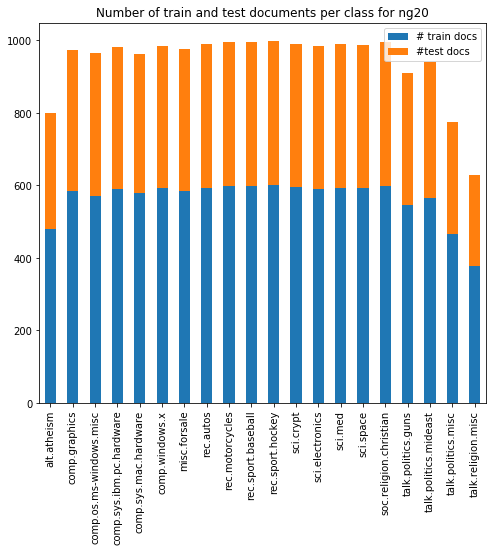

In [19]:
#Plot numbers of train and test documents per class for each dataset
countsdf.iloc[:-1,:-1].plot.bar(stacked=True, 
                                    figsize=(8, 7),
                                    title="Number of train and test documents per class for ng20")

In [17]:
#Counting the number of features 
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer()
countvect.fit(ng20traindf["text"])
with_stopwords = len(countvect.get_feature_names())
print("Number of features including stop words: ", with_stopwords)

count_vect = CountVectorizer(stop_words="english")
count_vect.fit(ng20traindf["text"])
without_stopwords = len(count_vect.get_feature_names())
print("Number of features excluding stop words: ", without_stopwords)

Number of features including stop words:  73686
Number of features excluding stop words:  73375


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [19]:
def to_tfidf(df_train, df_test):
    vec = TfidfVectorizer(stop_words='english', smooth_idf=False)
    vec.fit(df_train["text"])
    X_train = vec.transform(df_train["text"])
    y_train = df_train["label"]
    X_test = vec.transform(df_test["text"])
    y_test = df_test["label"]
    return X_train, y_train, X_test, y_test
    
def applymodel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

def applymodels(models, df_train, df_test, use_lsi=False):
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)
    if use_lsi:
        svd = TruncatedSVD(n_components=200, random_state=42)
        X_train = svd.fit_transform(X_train)
        X_test = svd.transform(X_test)

    return [(name, applymodel(model, X_train, y_train, X_test, y_test)) 
            for (name, model) in models]

In [20]:
classifiers = (
    ("Vector Method", KNeighborsClassifier(n_neighbors=1)),
    ("KNN (k=10)", KNeighborsClassifier(n_neighbors=10)),
    ("Centroid", NearestCentroid()),
    ("Naive Bayes", MultinomialNB(fit_prior=False)),
    ("SVM (Linear Kernel)", LinearSVC()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("SGD(StochasticGradientdescent)", SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100,tol=None)),
    ("RF(RandomForest)", RandomForestClassifier(n_estimators=100, n_jobs=1)),
)

In [21]:
ng20results = applymodels(classifiers, ng20traindf, ng20testdf)
ng20results

[('Vector Method', 0.7217056323060573),
 ('KNN (k=10)', 0.7450850159404888),
 ('Centroid', 0.7534537725823592),
 ('Naive Bayes', 0.8221307120085016),
 ('SVM (Linear Kernel)', 0.8471041445270988),
 ('Decision Tree', 0.5762486716259299),
 ('SGD(StochasticGradientdescent)', 0.8172157279489904),
 ('RD(RandomForest)', 0.7743092454835282)]

In [ ]:
#Optimising parameters by using GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
optmodels = (
    ("KNN", KNeighborsClassifier(), 
     {"n_neighbors" : [1, 5, 10, 20, 30, 40],
      "weights" : ["uniform", "distance"]}),
    ("Naive Bayes", MultinomialNB(),
     {"alpha" : [0.0, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0], 
      "fit_prior" : [True, False]}),
    ("SVM (Linear)", LinearSVC(), 
     [{"C" : [0.5, 1.0, 2.0, 4.0], "penalty" : ["l2"]},
      {"C" : [0.5, 1.0, 2.0, 4.0], "penalty" : ["l1"], "dual" : [False]}]),
    ("Decision Tree", DecisionTreeClassifier(random_state=42),
     {"criterion" : ["gini", "entropy"],
      "max_features" : [None, 10, "sqrt"],  
      "random_state" : [42]}),
    ("Random Forest", RandomForestClassifier(random_state=42),
     {"n_estimators" : [10, 30, 50, 70], 
      "criterion" : ["gini", "entropy"], 
      "random_state" : [42]}),
)

In [ ]:
def gridmodels(models, df_train, df_test):
    X_train, y_train, X_test, y_test = to_tfidf(df_train, df_test)

    results = []
    optimised_models = []
    for (name, model, params) in models:
        bare_model_score = applymodel(model, X_train, y_train, X_test, y_test)

        gcv = GridSearchCV(model, params)
        gcv.fit(X_train, y_train)
        optimized_score = applymodel(gcv.best_estimator_, X_train, y_train, X_test, y_test)
        results.append((name, bare_model_score, optimized_score, gcv.best_params_))
        
        if optimized_score > bare_model_score:
            optimised_models.append((name, gcv.best_estimator_))
        else:
            optimised_models.append((name, model))
    return results, optimised_models

In [ ]:
ng20resultsgrid, ng20optimisedmodels  = gridmodels(optmodels, ng20traindf, ng20testdf)
ng20resultsgrid

In [5]:
#Topic Modelling on 20newsgroup
from sklearn.datasets import fetch_20newsgroups
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [6]:
newsgroup = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(newsgroup.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [35]:
len(newsgroup)

11314

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nltk.corpus.reader.wordlist.WordListCorpusReader

In [8]:
docs = newsgroup.content.values.tolist()
docs = [re.sub('\S*@\S*\s?', '', sent) for sent in docs]
docs = [re.sub('\s+', ' ', sent) for sent in docs]
docs = [re.sub("\'", "", sent) for sent in docs]

In [9]:
docs

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This is all I know. If anyone can tellme a model name, engine specs, years of production, where this car is made, history, or whatever info you have on this funky looking car, please e-mail. Thanks, - IL ---- brought to you by your neighborhood Lerxst ---- ',
 'From: (Guy Kuo) Subject: SI Clock Poll - Final Call Summary: Final call for SI clock reports Keywords: SI,acceleration,clock,upgrade Article-I.D.: shelley.1qvfo9INNc3s Organization: University of Washington Lines: 11 NNTP-Posting-Host: carson.u.washington.edu A fair number of brave souls who upgraded t

In [10]:
def senttowords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(senttowords(docs))

In [38]:
len(data_words)

11314

In [39]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized)

In [ ]:
# vectorizer = CountVectorizer(analyzer='word', min_df=10,
#                             stop_words = stop_words,
#                             lowercase=True,
#                             token_pattern='[a-zA-Z0-9]{3,}')
# data_vectorized = vectorizer.fit_transform(data_lemmatized)
# print(data_vectorized.shape)

In [34]:
#Converting to document-term matrixd
docvect = CountVectorizer(analyzer='word',strip_accents='unicode', 
                         stop_words= stop_words, lowercase=True, 
                         token_pattern= '[a-zA-Z0-9]{3,}', 
                         max_df = 0.5, min_df = 10)
docmatrix = docvect.fit_transform(data_lemmatized)       
# for i, row in enumerate(dtmtf):
#      print (dtmtf[i])
print(docmatrix.shape)

(5660, 4401)


In [ ]:
#Materialize the sparse data
data_dense = dtmtf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

In [9]:
tfidfvect = TfidfVectorizer(**docvect.get_params(), use_idf=True)
dtmtfidf = tfidfvect.fit_transform(data_lemmatized)
# for i, row in enumerate(dtmtfidf):
#      print (dtmtfidf[i])
print(dtmtfidf.shape)
#tfidfvect.get_feature_names()

(5660, 4452)


In [12]:
#Fit LDA Models
#For DocumentMatrix
doclda = LatentDirichletAllocation(n_components=50,      
                                 learning_method='online')
docldaoutput = doclda.fit_transform(docmatrix)

In [ ]:
#For Term Frequency Inverse document frequecy matrix
# ldatfidfmodel = LatentDirichletAllocation(n_components=50,        #n_components = n_topics
#                                  learning_method='online')
# ldatfidfoutput = ldatfidfmodel.fit_transform(dtmtfidf)

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

In [13]:
#Using perplexity and log-likelihood for diagonising the model performance 
# Log Likelyhood: Higher the better
print("Log Likelihood: ", doclda.score(docmatrix))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", doclda.perplexity(docmatrix))

Log Likelihood:  -3042854.3493397613
Perplexity:  1444.4235389237226


In [ ]:
#Using perplexity and log-likelihood for diagonising the model performance for TF-IDF
# print("Log Likelihood: ", ldatfidfmodel.score(dtmtfidf))
# print("Perplexity: ", ldatfidfmodel.perplexity(dtmtfidf))

Performing Gridsearch for the best LDA model

In [14]:
search_params = {'n_components': [20, 30, 50], 'learning_decay': [.5, .7, .9]}
#Gridsearch for Document term matrix 
lda = LatentDirichletAllocation(learning_method='online')
model = GridSearchCV(lda, param_grid=search_params)
model.fit(docmatrix)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [20, 30, 50], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
#Gridsearch for TFIDF matrix
# lda1 = LatentDirichletAllocation(learning_method='online')
# model1 = GridSearchCV(lda1, param_grid=search_params)
# model1.fit(dtmtfidf)

In [15]:
#Finding out the best model of n topics
bestdocldamodel = model.best_estimator_
#bestmodeltfidf = model1.best_estimator_
print("Best Model's Params: ", bestdocldamodel)
#print("Best Model's Params: ", bestmodeltfidf)
print("ModelDTM loglikelihood: ", bestdocldamodel.score(docmatrix))
print("ModelDTM perplexity: ", bestdocldamodel.perplexity(docmatrix))
# print("ModelTFDIF loglikelihood: ", bestmodeltfidf.score(dtmtfidf))
# print("ModelTFDIF perplexity: ", bestmodeltfidf.perplexity(dtmtfidf))

Best Model's Params:  LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
ModelDTM loglikelihood:  -3020696.227618561
ModelDTM perplexity:  1369.8897084792447


In [17]:
#Finding out the dominant topic in each document 
#Creating Document-Topic matrix
#ldadfoutput = ldadfmodel.fit_transform(dtmtf)
ldadfoutput = bestdocldamodel.fit_transform(docmatrix)
topicnames = ["Topic" + str(i) for i in range(bestdocldamodel.n_components)]
docnames = ["Doc" + str(i) for i in range(len(docs))]
# Make the pandas dataframe
documenttopic = pd.DataFrame(np.round(ldadfoutput, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(documenttopic.values, axis=1)
documenttopic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
documenttopics = documenttopic.head(15).style.applymap(color_green).applymap(make_bold)
documenttopics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0,0.07,0,0,0,0,0.14,0.15,0,0,0,0,0.05,0,0.08,0,0,0,0,0.46,19
Doc1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0
Doc2,0,0.09,0,0,0.3,0.46,0,0,0,0,0,0,0.09,0,0,0,0,0,0,0,5
Doc3,0,0,0,0.22,0,0,0,0,0,0.03,0.11,0,0,0,0,0,0,0,0.03,0.6,19
Doc4,0,0,0,0,0,0,0,0.03,0,0,0,0.53,0,0.41,0,0,0,0,0,0,11
Doc5,0,0,0,0.49,0,0,0,0,0,0.44,0,0,0,0,0,0,0,0,0,0,3
Doc6,0,0,0,0.29,0,0,0,0,0.69,0,0,0,0,0,0,0,0,0,0,0,8
Doc7,0.22,0,0,0.28,0.34,0,0,0,0,0,0,0.03,0,0.01,0.13,0,0,0,0,0,4
Doc8,0,0.06,0,0.25,0,0.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
Doc9,0.02,0,0,0,0,0,0,0.02,0.02,0,0.32,0,0.08,0,0.02,0,0,0,0,0.52,19


In [18]:
topicdistribution = documenttopic['dominant_topic'].value_counts().reset_index(name="Num Documents")
topicdistribution.columns = ['Topic Num', "Num Documents"]
topicdistribution

,Topic Num,Num Documents
0,3,1759
1,19,962
2,5,633
3,11,504
4,4,331
5,0,317
6,13,310
7,7,254
8,10,114
9,8,112


In [32]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.display(pyLDAvis.sklearn.prepare(doclda, docmatrix, docvect))
panel

#Issue with the jupyterLab called an enquired

In [21]:
#Topic-Keyword Matrix
topickeywords = pd.DataFrame(bestdocldamodel.components_)
topickeywords.columns = docvect.get_feature_names()
topickeywords.index = topicnames
topickeywords.head()

,aaa,aaron,abandon,abc,abide,ability,able,abortion,about,above,...,york,young,yount,yours,youth,ysebaert,yzerman,zip,zone,zoom
Topic0,0.050000,2.611477,0.050003,0.050001,0.050000,1.453629,0.050369,0.050000,2.440194,0.050001,...,1.853098,0.050002,0.050001,0.050001,0.050000,0.050000,0.050000,13.607895,0.050002,0.050001
Topic1,0.050000,0.050000,0.050001,0.050000,0.050001,0.050001,0.050002,0.050000,0.050001,0.050000,...,0.050008,0.050002,0.050000,0.050001,0.050000,0.050000,0.050000,3.353862,0.050001,0.050000
Topic2,0.050001,0.050000,0.050001,0.050000,0.050000,0.050001,0.050001,0.050000,0.050026,0.050000,...,0.050001,0.050000,0.050000,0.050001,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
Topic3,1.344293,0.050022,0.050001,0.050006,0.052464,2.387736,140.633771,0.050000,103.900580,0.050001,...,0.205937,61.870778,0.050004,0.050001,4.310591,0.050017,0.050006,0.050001,0.050022,0.050000
Topic4,0.050002,0.050001,0.050003,0.050000,0.050001,12.483561,49.232802,0.050142,15.692839,0.050004,...,0.050010,0.050008,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050001,0.050000


In [23]:
# Show top n keywords for each topic
def show_topics(vectorizer=docvect, lda_model=bestdocldamodel, n_words=20):
    keywords = np.array(docvect.get_feature_names())
    topic_keywords = []
    for topic_weights in bestdocldamodel.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=docvect, lda_model=bestdocldamodel, n_words=15)        

# Topic - Keywords Dataframe
dftopickeywords = pd.DataFrame(topic_keywords)
dftopickeywords.columns = ['Word '+str(i) for i in range(dftopickeywords.shape[1])]
dftopickeywords.index = ['Topic '+str(i) for i in range(dftopickeywords.shape[0])]
dftopickeywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,space,file,launch,nasa,satellite,program,system,will,technology,shuttle,cost,datum,year,station,center
Topic 1,gun,weapon,firearm,state,government,crime,use,control,kill,criminal,right,fire,bill,handgun,carry
Topic 2,mile,gas,fix,brake,tire,truck,revolver,trigger,problem,change,mask,look,toyota,everywhere,com
Topic 3,would,get,think,can,that,good,what,just,there,will,see,when,know,say,who
Topic 4,which,use,more,ground,there,time,will,may,high,other,that,most,can,circuit,such
Topic 5,would,thank,can,price,use,anyone,know,mail,get,what,there,send,that,want,post
Topic 6,information,april,send,may,include,available,contact,usa,university,list,group,institute,apr,internet,world
Topic 7,game,team,play,player,season,will,wire,league,good,point,hockey,goal,get,nhl,score
Topic 8,run,year,win,hit,last,good,pitch,average,cub,player,first,lose,pitcher,baseball,base
Topic 9,earth,moon,orbit,lunar,star,sun,mission,probe,space,image,solar,spacecraft,mar,mass,surface


In [25]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global senttowords
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(senttowords(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = docvect.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = bestdocldamodel.transform(mytext_4)
    topic = dftopickeywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# # Predict the topic
mytext = ["Nasa mars mission probe"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['earth', 'moon', 'orbit', 'lunar', 'star', 'sun', 'mission', 'probe', 'space', 'image', 'solar', 'spacecraft', 'mar', 'mass', 'surface']


In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(docldaoutput)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
ldaoutputsvd = svd_model.fit_transform(docldaoutput)
# X and Y axes of the plot using SVD decomposition
x = ldaoutputsvd[:, 0]
y = ldaoutputsvd[:, 1]
print("Component's weights: \n", np.round(svd_model.components_, 2))
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.02  0.01  0.15  0.01  0.    0.01  0.    0.87  0.01  0.    0.02  0.01
   0.02  0.08  0.    0.02  0.05  0.    0.04  0.    0.    0.01  0.02  0.01
   0.01  0.01  0.14  0.02  0.01  0.37  0.    0.    0.01  0.01  0.02  0.01
   0.01  0.17  0.    0.08  0.04  0.01  0.01  0.05  0.04  0.01  0.06  0.06
   0.03  0.05]
 [ 0.    0.   -0.01  0.01  0.    0.    0.   -0.44  0.    0.    0.    0.
   0.01  0.02  0.    0.   -0.01  0.    0.02  0.    0.    0.01  0.01  0.
   0.01  0.    0.37  0.    0.    0.79  0.    0.    0.    0.    0.01  0.
   0.    0.18  0.    0.01  0.01  0.    0.01  0.01  0.01  0.    0.04  0.02
   0.01  0.02]]
Perc of Variance Explained: 
 [0.12 0.22]


Text(0.5,1,'Segregation of Topic Clusters')

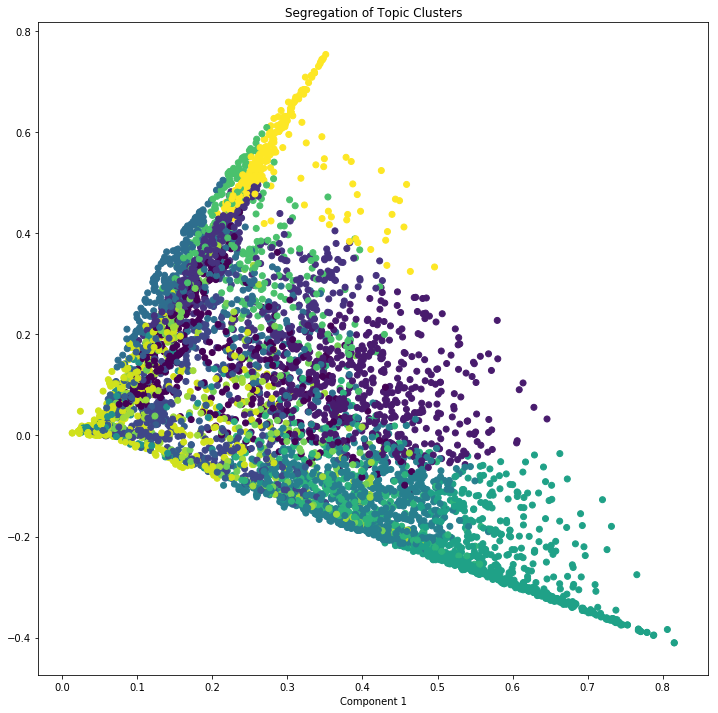

In [28]:
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

TOPIC MODELING WITH GENSIM

In [11]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [36]:
#Creating Bigram and Trigram Models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/Users/akashbachu/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [39]:
print(trigram_mod[bigram_mod[data_words[500]]])

['are', 'you', 'two', 'joking', 'is', 'the', 'entire', 'internet', 'flaming', 'you', 'two', 'ahh', 'now', 'remember', 'that', 'ohmite_company', 'was', 'the', 'first', 'introducing', 'the', 'pink', 'colored', 'resistor', 'only', 'for', 'electronics', 'working', 'females']


In [51]:
#Removing stopwords 
def remove_stopwrds(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return[bigram_mod[doc] for doc in texts]

def make_trigram(texts):
    return[trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [55]:
datanosw = remove_stopwrds(data_words)
databigram = make_bigrams(datanosw)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
datalemmatizedgensim = lemmatization(databigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(datalemmatizedgensim[:1])

[['frank', 'crary', 'university', 'colorado', 'boulder', 'stat', 'invalid', 'talk', 'backcountry', 'stat', 'rape', 'assault', 'death', 'represent', 'backcountry', 'singularly', 'great', 'majority', 'represent', 'urban', 'incident', 'point']]


In [46]:
#Dictionary and Corpus

In [57]:
id2word= corpora.Dictionary(datalemmatizedgensim)
texts = datalemmatizedgensim
corpus = [id2word.doc2bow(text) for text in texts]

In [61]:
print(corpus[:78])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1)], [(19, 1)], [(20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)], [(32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1)], [(64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 2), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1)], [(34, 3), (48, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 2), (107, 1), 

In [65]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:78]]

[[('assault', 1),
  ('backcountry', 2),
  ('boulder', 1),
  ('colorado', 1),
  ('crary', 1),
  ('death', 1),
  ('frank', 1),
  ('great', 1),
  ('incident', 1),
  ('invalid', 1),
  ('majority', 1),
  ('point', 1),
  ('rape', 1),
  ('represent', 2),
  ('singularly', 1),
  ('stat', 2),
  ('talk', 1),
  ('university', 1),
  ('urban', 1)],
 [('bilinsky', 1)],
 [('anyone', 1),
  ('area', 1),
  ('avaliable', 1),
  ('babak', 1),
  ('copy_protection', 1),
  ('effective', 1),
  ('experience', 1),
  ('high', 1),
  ('regard', 1),
  ('sehari', 1),
  ('technique', 1),
  ('wonder', 1)],
 [('agree', 1),
  ('apparently', 1),
  ('be', 1),
  ('can', 1),
  ('correctly', 1),
  ('do', 1),
  ('earth', 2),
  ('fact', 1),
  ('follow', 1),
  ('hold', 2),
  ('little', 1),
  ('logic', 1),
  ('marriage', 1),
  ('matthew', 1),
  ('maybe', 1),
  ('next', 1),
  ('not', 1),
  ('place', 1),
  ('priest', 1),
  ('read', 1),
  ('require', 2),
  ('seem', 1),
  ('shall', 1),
  ('take', 1),
  ('thing', 1),
  ('tired', 1),
  

In [70]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [74]:
pprint(ldamodel.print_topics())
doclda = ldamodel[corpus]

[(21,
  '0.033*"title" + 0.033*"cover" + 0.023*"quasar" + 0.023*"format" + '
  '0.022*"travel" + 0.022*"background" + 0.020*"past" + 0.017*"campaign" + '
  '0.017*"annual" + 0.015*"dark"'),
 (44,
  '0.042*"goal" + 0.029*"har" + 0.020*"penalty" + 0.016*"scoring" + '
  '0.011*"period" + 0.010*"zone" + 0.010*"puck" + 0.010*"winner" + '
  '0.010*"jagr" + 0.009*"lemieux"'),
 (48,
  '0.059*"red" + 0.053*"tv" + 0.032*"manager" + 0.024*"germany" + '
  '0.022*"constitution" + 0.021*"nazi" + 0.020*"east" + 0.018*"harm" + '
  '0.016*"cardinal" + 0.016*"gross"'),
 (41,
  '0.035*"church" + 0.030*"catholic" + 0.028*"animal" + 0.025*"disagree" + '
  '0.023*"conviction" + 0.018*"council" + 0.018*"prophethood" + 0.018*"style" '
  '+ 0.016*"roman" + 0.014*"muhammad_saw"'),
 (19,
  '0.034*"package" + 0.029*"super" + 0.029*"battery" + 0.027*"install" + '
  '0.027*"particularly" + 0.021*"chemical" + 0.016*"material" + 0.015*"simm" + '
  '0.015*"jet" + 0.013*"generator"'),
 (26,
  '0.056*"neutral" + 0.030*"

In [78]:
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))
coherencemodelda = CoherenceModel(model=ldamodel, texts = datalemmatizedgensim, dictionary=id2word, coherence='c_v')
coherencelda = coherencemodelda.get_coherence()
print('\nCoherence Score: ', coherencelda)


Perplexity:  -9.007022255744513

Coherence Score:  0.452906019030141


In [80]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=50, id2word=id2word)

In [85]:
pprint(ldamallet.show_topics(formatted=False))
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=datalemmatizedgensim, dictionary=id2word, coherence='c_v')
coherenceldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score using mallet algorithm: ', coherenceldamallet)


[(29,
  [('game', 0.06436924350615751),
   ('play', 0.03694504812170134),
   ('team', 0.02669978267618752),
   ('goal', 0.02473351961088689),
   ('point', 0.024009106902618236),
   ('season', 0.02090448101003829),
   ('flyer', 0.013867328986857084),
   ('win', 0.01334989133809376),
   ('puck', 0.012625478629825106),
   ('penalty', 0.012004553451309118)]),
 (4,
  [('state', 0.04640605296343001),
   ('law', 0.027616645649432534),
   ('bill', 0.02459016393442623),
   ('people', 0.021437578814627996),
   ('government', 0.01651954602774275),
   ('public', 0.015636822194199245),
   ('individual', 0.013366960907944515),
   ('militia', 0.012736443883984868),
   ('vote', 0.01223203026481715),
   ('provide', 0.011601513240857503)]),
 (44,
  [('gun', 0.06615591676156952),
   ('file', 0.03033440314732374),
   ('firearm', 0.024226110363391656),
   ('crime', 0.021016668392173102),
   ('criminal', 0.01780722642095455),
   ('handgun', 0.016875452945439486),
   ('weapon', 0.013666010974220934),
   ('ra

In [108]:
#Finding the optimal number of topics
def computecv(dictionary, corpus, texts, limit, start=2, step=3):
    cohvalues = []
    modellist = []
    for num_topics in range(start, limit, step):
        model= gensim.models.wrappers.LdaMallet(mallet_path, corpus= corpus,num_topics = num_topics, id2word=id2word)
        modellist.append(model)
        coherencemodel = CoherenceModel(model=model, texts = texts, dictionary=dictionary, coherence='c_v')
        cohvalues.append(coherencemodel.get_coherence())
    
    return modellist, cohvalues
        

In [109]:
modellist, cohvalues = computecv(dictionary=id2word, corpus=corpus, texts=datalemmatizedgensim, start=20, limit=60, step=10)


In [111]:
limit= 60; start = 20; step = 10;
x = range(start, limit, step)

In [112]:
# Print the coherence scores
for m, cv in zip(x, cohvalues):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.5935
Num Topics = 30  has Coherence Value of 0.5718
Num Topics = 40  has Coherence Value of 0.5679
Num Topics = 50  has Coherence Value of 0.5629


In [113]:
# Select the model and print the topics
optimal_model = modellist[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(48,
  '0.049*"people" + 0.038*"state" + 0.026*"government" + 0.020*"war" + '
  '0.018*"weapon" + 0.014*"individual" + 0.014*"militia" + 0.012*"force" + '
  '0.011*"country" + 0.011*"protect"'),
 (1,
  '0.083*"year" + 0.036*"money" + 0.032*"pay" + 0.029*"guy" + 0.028*"ill" + '
  '0.025*"day" + 0.024*"give" + 0.019*"back" + 0.018*"remember" + '
  '0.017*"spend"'),
 (4,
  '0.054*"space" + 0.025*"nasa" + 0.018*"program" + 0.016*"shuttle" + '
  '0.015*"flight" + 0.013*"technology" + 0.013*"mission" + 0.012*"option" + '
  '0.010*"center" + 0.010*"research"'),
 (14,
  '0.022*"year" + 0.019*"fan" + 0.019*"day" + 0.018*"move" + 0.018*"home" + '
  '0.017*"red" + 0.016*"city" + 0.016*"night" + 0.015*"ticket" + '
  '0.013*"place"'),
 (25,
  '0.047*"high" + 0.029*"low" + 0.029*"cost" + 0.028*"work" + 0.024*"speed" + '
  '0.023*"design" + 0.018*"small" + 0.018*"large" + 0.017*"fast" + '
  '0.017*"real"'),
 (6,
  '0.031*"exist" + 0.027*"reason" + 0.021*"truth" + 0.019*"question" + '
  '0.018*"true"

In [ ]:
#To perform Gensim LDA I took the raw 20newsgroup datset without train and test and performed LDA.
#Next steps is to split the dataset in 70:30 and classify it.
#The same thing will be done to Reuters data

with open('newsgroup_all.txt') as f:
    datalda = f.readlines()
    
lines = []
for num in datalda:
     if type(num) != float:
        lines.append(num.replace("_"," "))


newlines = []
for line in lines:
    newlines.append(line.translate({ord(k): None for k in digits}))



tokenizer = RegexpTokenizer(r'\b[a-zA-Z]{3,}\b')
en_stop = get_stop_words('en')

texts = []
for i in newlines:
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
     # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
     # stem tokens
     # add tokens to list
    texts.append(stopped_tokens)

i = 0
while i < 5:
    i +=1
    for sentence in texts:
        for word in sentence:
            if word  == 's':
                sentence.remove(word)

print(texts)               


In [ ]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldagensim = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, 
                                              num_topics=20, chunksize=10000, passes=5)

In [ ]:
topics = ldagensim.show_topics(num_topics=20, formatted=False, num_words=100)
for t in range(len(topics)):
    print("\nTopic {}, top {} words:".format(t+1,100))
    print(" ".join([w[0] for w in topics[t][1]]))

In [ ]:
print(ldagensim.print_topics(num_topics=20))

In [ ]:
#ldagensim1 = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=dictionary,num_topics=20, chunksize=10000, 
                                                    #passes=5, workers=2)
    
#It is not working


In [ ]:
#train the model and classify it using SVM and other classifiers



In [ ]:
#Use word2vec

In [ ]:
from nltk.tokenize import word_tokenize
ng20traindata = ng20train.data
def get_tokens(text):
    tokens = word_tokenize(text)
    return [token.lower() for token in tokens]
print(get_tokens(ng20traindata[0]))

In [ ]:
sentences = [get_tokens(doc) for doc in ng20traindata]
print(sentences[0])

In [ ]:
model_ng = gensim.models.word2vec.Word2Vec(sentences,min_count=3,size=200)
sents = gensim.models.word2vec.Text8Corpus('text8', max_sentence_length=10000)
model_t8 = gensim.models.word2vec.Word2Vec(sents,min_count=5,size=200,iter=15)

In [ ]:
model_t8.most_similar('food')

In [ ]:
model_t8.most_similar(positive=['woman', 'king'], negative=['man'])


In [ ]:
from gensim.models.doc2vec import TaggedDocument
sentences = [get_tokens(doc) for doc in ng20traindata]
tagged_documents = []
for i, sent in enumerate(sentences):
    tagged_documents.append(TaggedDocument(sent,["sent_{}".format(i)]))
d2v_model = gensim.models.doc2vec.Doc2Vec(tagged_documents, size=300)

In [ ]:
d2v_model.most_similar('work')

In [ ]:
cd datasets/

In [12]:
from sklearn.cross_validation import train_test_split
docstrain, docstest = train_test_split(docs, train_size = 0.7)

In [13]:
dfs = [docstrain, docstest]
dfnames = ["docstrain", "docstest"]
for (df, name) in zip(dfs, dfnames):
    print(name, "(#rows, #columns):", df.shape)

AttributeError: 'list' object has no attribute 'shape'

pandas.core.frame.DataFrame